In [1]:
import db_model as dm
import update_rating as ur
from matplotlib import pyplot
import numpy as np
from scipy.stats import norm, ttest_1samp
import ipyparallel as ipp
from multiprocess import Pool
from peewee import DatabaseError
from numba import jit, float64, int32, types
import numba as nb

import copy

threads = 10
week = 1
STAGE = 2
WEEK = (STAGE-1)*5+week

In [2]:
def initialize_and_update(WEEK):
    ur.initialize()
    for week in range(0,WEEK+1):
        ur.update(week,5)

In [3]:
initialize_and_update(WEEK)

In [4]:
ratings = dm.Rating.select().where(dm.Rating.week==WEEK).order_by(-dm.Rating.rating)

for rating in ratings:
    print('{0}|{1:.0f}±{2:.0f}'.format(rating.team.name, rating.rating, rating.RD*2))

LDN|1630±128
NYE|1630±131
HOU|1615±129
BOS|1612±131
VAL|1605±131
SEO|1550±131
PHI|1441±134
DAL|1438±131
GLA|1426±131
SFS|1419±129
FLA|1322±133
SHD|1290±136


In [5]:
matches = dm.Match.select()

@jit(nopython=True)
def matchscore_func(E):
    return (E**4, 4*E**3*(1-E),6*E**2*(1-E)**2*(E),6*E**2*(1-E)**2*(1-E), 4*(1-E)**3*E, (1-E)**4)

score = [0,0]
game_score = [0,0]
squared_prediction_error = 0

for match in matches:
    if match.week>=2:
        team1 = match.team1
        rating1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==match.week-1).rating
        RD1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==match.week-1).RD

        team2 = match.team2
        rating2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==match.week-1).rating
        RD2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==match.week-1).RD
        RD = np.sqrt(RD1**2+RD2**2)        
        E = ur.E(RD, rating1, rating2)
        match_score = (match.wins+match.draws/2)/(match.wins+match.draws+match.losses)
        matchscore_probability = matchscore_func(E)
        exp_val = matchscore_probability[0]+matchscore_probability[1]*0.75+matchscore_probability[2]*0.6+\
                    matchscore_probability[3]*0.4+matchscore_probability[4]*0.25
        squared_prediction_error = squared_prediction_error+(match_score-exp_val)**2
        if np.sign(match_score-0.5) == np.sign(E-0.5):
            score[0] = score[0] + 1
        else:
            score[1] = score[1] + 1
        predicted_matchscore = np.argmax(matchscore_probability)
        if predicted_matchscore == 0:
            wins = 4
            losses = 0
        elif predicted_matchscore == 1:
            wins = 3
            losses = 1
        elif predicted_matchscore == 2:
            wins = 3
            losses = 2
        elif predicted_matchscore == 3:
            wins = 2
            losses = 3
        elif predicted_matchscore == 4:
            wins = 1
            losses = 3
        elif predicted_matchscore == 5:
            wins = 0
            losses = 4
        
        if (match.wins == wins) and (match.losses == losses) and (match.draws == 0):
            game_score[0] = game_score[0] + 1
        else:
            game_score[1] = game_score[1] + 1

In [6]:
print(score)
print(game_score)
print(squared_prediction_error)
print(squared_prediction_error+score[1]/5)

[37, 13]
[10, 40]
4.2468022655537006
6.8468022655537


In [7]:
teams = dm.Team.select()

fig, ax = pyplot.subplots(figsize=(10,6))
X = range(WEEK)

for team in teams:
    Y = [dm.Rating.get(dm.Rating.team==team, dm.Rating.week==x).rating for x in X]
    ax.plot(X, Y, '-o', label=team.name, color=team.color2, markerfacecolor=team.color1, markeredgecolor=team.color3,markersize=10)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(bbox_to_anchor=(1, 1.0))
pyplot.show()

In [8]:
X = np.linspace(1000,2000,200)

fig, ax = pyplot.subplots(figsize=(10,6))
Y=[]
color_list=[]
for team in teams:
    Y.append(norm.pdf(X,dm.Rating.get(dm.Rating.team==team, dm.Rating.week==WEEK).rating,dm.Rating.get(dm.Rating.team==team, dm.Rating.week==WEEK).RD))
    color_list.append(team.color1)
    ax.plot(X,norm.pdf(X,dm.Rating.get(dm.Rating.team==team, dm.Rating.week==WEEK).rating,dm.Rating.get(dm.Rating.team==team, dm.Rating.week==WEEK).RD), alpha=0.5, color=team.color1)
    ax.fill(X,norm.pdf(X,dm.Rating.get(dm.Rating.team==team, dm.Rating.week==WEEK).rating,dm.Rating.get(dm.Rating.team==team, dm.Rating.week==WEEK).RD), alpha=0.3, label=team.name, color=team.color1)
l = ax.legend()
pyplot.show()

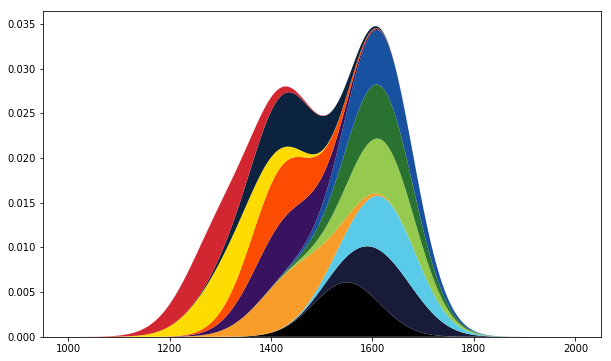

In [9]:
fig, ax = pyplot.subplots(figsize=(10,6))
ax.stackplot(X,Y,colors=color_list)
pyplot.show()

# Important Match Penalty?

The hypothesis being tested here is that if there are important matches, where important is defined as either a playoff match or a match that is expected to be close (0.3-0.7 expected value), the team with more important matches performs worse that week.

Also, we expect that this penalty would not be present in the first week of each stage as teams have more time to prepare.

In [10]:
lower_bound=0.3
upper_bound=1-lower_bound

def no_of_impt_matches(week, team):
    matches = dm.Match.select().where(((dm.Match.team1 == team) | (dm.Match.team2 == team)) & (dm.Match.week == week))
    futurematches = dm.FutureMatch.select().where(((dm.FutureMatch.team1 == team) | (dm.FutureMatch.team2 == team)) & (dm.FutureMatch.week == week))
    important = 0
    for match in matches:
        team1 = match.team1
        rating1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==match.week).rating
        RD1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==match.week).RD
        team2 = match.team2
        rating2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==match.week).rating
        RD2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==match.week).RD
        RD = np.sqrt(RD1**2+RD2**2)
        E = ur.E(RD, rating1, rating2)
        if ((E>lower_bound) and (E<upper_bound)) or (match.day == 5):
            important = important + 1
    for match in futurematches:
        team1 = match.team1
        rating1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==WEEK).rating
        RD1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==WEEK).RD

        team2 = match.team2
        rating2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==WEEK).rating
        RD2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==WEEK).RD
        RD = np.sqrt(RD1**2+RD2**2)
        E = ur.E(RD, rating1, rating2)
        if ((E>lower_bound) and (E<upper_bound)) or (match.day == 5):
            important = important + 1
    return important

In [11]:
important_matches = {}
for week in range(11):
    for team in teams:
        important_matches[(week,team)] = no_of_impt_matches(week,team)
prediction_error={}
teams = dm.Team.select()
for week in range(2,WEEK+1):
    matches = dm.Match.select().where((dm.Match.week == week))
    for match in matches:
        team1 = match.team1
        rating1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==match.week-1).rating
        RD1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==match.week-1).RD
        team2 = match.team2
        rating2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==match.week-1).rating
        RD2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==match.week-1).RD
        RD = np.sqrt(RD1**2+RD2**2)
        E = ur.E(RD, rating1, rating2)
        if important_matches[(match.week,match.team1)] > important_matches[(match.week,match.team2)] and week%5!=1:
            n=1
        elif important_matches[(match.week,match.team2)] > important_matches[(match.week,match.team1)] and week%5!=1:
            n=-1
        else:
            n=0
        matchscore_probability = matchscore_func(E)
        exp_val = matchscore_probability[0]+matchscore_probability[1]*0.75+matchscore_probability[2]*0.6+\
                    matchscore_probability[3]*0.4+matchscore_probability[4]*0.25
        matchscore = (match.wins+0.5*match.draws)/(match.wins+match.draws+match.losses)
        if n==0:
            dE = matchscore-exp_val
        elif n>0:
            dE = matchscore-exp_val
        elif n<0:
            dE = exp_val-matchscore
        if abs(n) in prediction_error:
            prediction_error[abs(n)].append(dE)
        else:
            prediction_error[abs(n)] = [dE]

0|22|-0.02073792168193681±0.05845180652329169
1|28|-0.10176758971792714±0.0559771236238652


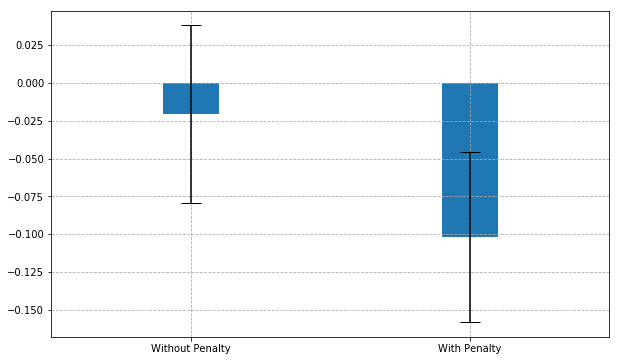

In [12]:
X = []
Y = []
Y_err = []
for n in range(len(prediction_error)):
    X.append(n)
    Y.append(sum(prediction_error[n])/len(prediction_error[n]))
    if len(prediction_error[n])>3:
        Y_err.append(np.std(prediction_error[n],ddof=1)/np.sqrt(len(prediction_error[n])))
    else:
        Y_err.append(0.2)
    print('{}|{}|{}±{}'.format(n, len(prediction_error[n]), Y[n], Y_err[n]))

fig, ax = pyplot.subplots(figsize=(10,6))
grid = ax.grid(b=True, which='major', color='#AAAAAA', linestyle='--')
data_plot = ax.bar(X, Y, 0.2, yerr=Y_err, capsize=10)
ax.set_xticks((0,1))
ax.set_xticklabels(('Without Penalty', 'With Penalty'))
ax.set_xlim((-0.5,1.5))
pyplot.show()
CORRECTION = Y[1]

In [13]:
print(ttest_1samp(prediction_error[0],0))
print(ttest_1samp(prediction_error[1],0))
print(CORRECTION)

Ttest_1sampResult(statistic=-0.3547866681190295, pvalue=0.7262875928404376)
Ttest_1sampResult(statistic=-1.818021061634894, pvalue=0.08017331361082983)
-0.10176758971792714


In [14]:
@jit(nopython=True)
def deltaE(E):
    #This is a first-order expansion. Not entirely accurate, but the correction is only ~0.1.
    dE = CORRECTION / (6*E**4 - 12*E**3 + 7.2*E**2 - 1.2*E + 1)
    if E+dE<1 and E+dE>0:
        return dE
    else:
        return 0

def predict(week, team1, team2, prnt, p_week=week, use_correction=True):
    RD = np.sqrt(dm.Rating.get(dm.Rating.week==week, dm.Rating.team==team1).RD**2+dm.Rating.get(dm.Rating.week==week, dm.Rating.team==team2).RD**2)
    r1 = dm.Rating.get(dm.Rating.week==week, dm.Rating.team==team1).rating
    r2 = dm.Rating.get(dm.Rating.week==week, dm.Rating.team==team2).rating
    E = ur.E(RD,r1,r2)
    
    if important_matches[(p_week,team1)] > important_matches[(p_week,team2)] and p_week%5!=1:
        n=1
        disadvantaged_team = team1.name
    elif important_matches[(p_week,team2)] > important_matches[(p_week,team1)] and p_week%5!=1:
        n=-1
        disadvantaged_team = team2.name
    else:
        n=0
        disadvantaged_team = '-'
    if use_correction == True:
        E = E+deltaE(E)*n
    
    matchscore_probability = (E**4, 4*E**3*(1-E),6*E**2*(1-E)**2*(E),6*E**2*(1-E)**2*(1-E), 4*(1-E)**3*E, (1-E)**4)
    if prnt==1:
        max_index = np.argmax(matchscore_probability)
        matchscore_str = []
        for x in matchscore_probability:
            matchscore_str.append('{:.2f}'.format(x))
        matchscore_str[max_index] = '**' + matchscore_str[max_index] + '**'
        print('{0} v {1}|{2[0]}|{2[1]}|{2[2]}|{2[3]}|{2[4]}|{2[5]}|{3:.3f}|{4}'.format(team1.name, team2.name, matchscore_str, E**4+4*E**3*(1-E)+6*E**2*(1-E)**2*(E),disadvantaged_team))
    else:
        return matchscore_probability

In [15]:
futurematches = dm.FutureMatch.select().where(dm.FutureMatch.week == WEEK)
for match in futurematches:
    predict(WEEK, match.team1, match.team2, 1, p_week=WEEK)

SEO v VAL|0.03|0.18|0.15|0.21|**0.32**|0.11|0.360|-
DAL v SHD|0.23|**0.41**|0.19|0.08|0.08|0.01|0.829|-
GLA v SFS|0.07|**0.26**|0.19|0.18|0.24|0.06|0.518|-
HOU v LDN|0.05|0.23|0.18|0.19|**0.27**|0.07|0.461|-
NYE v FLA|**0.51**|0.37|0.09|0.02|0.01|0.00|0.971|-
BOS v PHI|0.27|**0.42**|0.18|0.07|0.06|0.01|0.862|-
LDN v NYE|0.06|**0.25**|0.19|0.19|0.25|0.06|0.501|-
DAL v GLA|0.07|**0.27**|0.19|0.18|0.23|0.05|0.533|-
SFS v SEO|0.01|0.09|0.09|0.20|**0.40**|0.21|0.200|-
PHI v FLA|0.19|**0.39**|0.20|0.10|0.11|0.01|0.778|-
BOS v HOU|0.06|0.25|0.19|0.19|**0.25**|0.06|0.492|-
SHD v VAL|0.00|0.01|0.01|0.08|0.37|**0.52**|0.026|-


## Backtesting with correction

In [16]:
matches = dm.Match.select()
game_score = [0,0]
score = [0,0]
squared_prediction_error = 0

for match in matches:
    if match.week>=2:
        team1 = match.team1
        rating1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==match.week-1).rating
        RD1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==match.week-1).RD

        team2 = match.team2
        rating2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==match.week-1).rating
        RD2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==match.week-1).RD
        RD = np.sqrt(RD1**2+RD2**2)
        if important_matches[(match.week,match.team1)] > important_matches[(match.week,match.team2)] and match.week%5!=1:
            n=1
        elif important_matches[(match.week,match.team2)] > important_matches[(match.week,match.team1)] and match.week%5!=1:
            n=-1
        else:
            n=0
        E = ur.E(RD, rating1, rating2)
        E = E + deltaE(E)*n
        match_score = (match.wins+match.draws/2)/(match.wins+match.draws+match.losses)
        matchscore_probability = (E**4, 4*E**3*(1-E),6*E**2*(1-E)**2*(E),6*E**2*(1-E)**2*(1-E), 4*(1-E)**3*E, (1-E)**4)
        exp_val = matchscore_probability[0]+matchscore_probability[1]*0.75+matchscore_probability[2]*0.6+\
                    matchscore_probability[3]*0.4+matchscore_probability[4]*0.25
        squared_prediction_error = squared_prediction_error+(match_score-exp_val)**2
        if np.sign(match_score-0.5) == np.sign(E-0.5):
            score[0] = score[0] + 1
        else:
            score[1] = score[1] + 1
        
        predicted_matchscore = np.argmax(matchscore_probability)
        if predicted_matchscore == 0:
            wins = 4
            losses = 0
        elif predicted_matchscore == 1:
            wins = 3
            losses = 1
        elif predicted_matchscore == 2:
            wins = 3
            losses = 2
        elif predicted_matchscore == 3:
            wins = 2
            losses = 3
        elif predicted_matchscore == 4:
            wins = 1
            losses = 3
        elif predicted_matchscore == 5:
            wins = 0
            losses = 4
        if (match.wins == wins) and (match.losses == losses) and (match.draws == 0):
            game_score[0] = game_score[0] + 1
        else:
            game_score[1] = game_score[1] + 1
print(score)
print(game_score)
print(squared_prediction_error)

[38, 12]
[11, 39]
3.9733582504077685


### What about day-by-day predictions?

Spoiler: They aren't as good.

In [17]:
'''ur.initialize()
for week in range(0,WEEK+1):
    ur.update(week,5)
score = [0,0]
squared_prediction_error = 0
for week in range(2,WEEK+1):
    for day in range(1,6):
        matches = dm.Match.select().where(dm.Match.day == day, dm.Match.week == week)
        for match in matches:
            if day==1:
                rating_day = 4
                rating_week = week-1
            else:
                rating_day = day-1
                rating_week = week
            team1 = match.team1
            rating1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==rating_week).rating
            RD1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==rating_week).RD

            team2 = match.team2
            rating2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==rating_week).rating
            RD2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==rating_week).RD

            RD = np.sqrt(RD1**2+RD2**2)

            E = ur.E(RD, rating1, rating2)
            match_score = (match.wins+match.draws/2)/(match.wins+match.draws+match.losses)
            squared_prediction_error = squared_prediction_error+(match_score-E)**2
            if np.sign(match_score-0.5) == np.sign(E-0.5):
                score[0] = score[0] + 1
            else:
                score[1] = score[1] + 1
        ur.update(week,day)
        '''

'ur.initialize()\nfor week in range(0,WEEK+1):\n    ur.update(week,5)\nscore = [0,0]\nsquared_prediction_error = 0\nfor week in range(2,WEEK+1):\n    for day in range(1,6):\n        matches = dm.Match.select().where(dm.Match.day == day, dm.Match.week == week)\n        for match in matches:\n            if day==1:\n                rating_day = 4\n                rating_week = week-1\n            else:\n                rating_day = day-1\n                rating_week = week\n            team1 = match.team1\n            rating1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==rating_week).rating\n            RD1 = dm.Rating.get(dm.Rating.team==team1, dm.Rating.week==rating_week).RD\n\n            team2 = match.team2\n            rating2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==rating_week).rating\n            RD2 = dm.Rating.get(dm.Rating.team==team2, dm.Rating.week==rating_week).RD\n\n            RD = np.sqrt(RD1**2+RD2**2)\n\n            E = ur.E(RD, rating1, rating2)

In [18]:
'''score'''

'score'

In [19]:
'''squared_prediction_error'''

'squared_prediction_error'

# Prediction of Playoffs

In [20]:
team_dict = {}
teams = dm.Team.select()
for team in teams:
    match_score = 0
    game_score = 0
    teams_beat = []
    matches1 = dm.Match.select().where(dm.Match.week > (STAGE-1)*5, dm.Match.team1 == team)
    matches2 = dm.Match.select().where(dm.Match.week > (STAGE-1)*5,dm.Match.team2 == team)
    for match in matches1:
        if match.wins>match.losses:
            match_score = match_score + 1
            teams_beat.append(match.team2)
        elif match.wins<match.losses:
            match_score = match_score - 1
        game_score = game_score + match.wins - match.losses
    for match in matches2:
        if match.wins<match.losses:
            match_score = match_score + 1
            teams_beat.append(match.team1)
        elif match.wins>match.losses:
            match_score = match_score - 1
        game_score = game_score - match.wins + match.losses
    team_dict[team] = [match_score, game_score, teams_beat]

In [21]:
def compare(team1, team2, team_dict):
    if team_dict[team1][0] > team_dict[team2][0]:
        return True
    elif team_dict[team1][0] < team_dict[team2][0]:
        return False
    elif team_dict[team1][1] > team_dict[team2][1]:
        return True
    elif team_dict[team1][1] < team_dict[team2][1]:
        return False
    elif (team2 in team_dict[team1][2]) and (team1 not in team_dict[team2][2]):
        return True
    elif (team1 in team_dict[team2][2]) and (team2 not in team_dict[team1][2]):
        return False
    elif (team1 in team_dict[team2][2]) and (team2 in team_dict[team1][2]):
        team1_wins = team_dict[team1][2].count(team2)
        team2_wins = team_dict[team2][2].count(team1)
        if team1_wins > team2_wins:
            return True
        elif team2_wins > team1_wins:
            return False            
    else:
        #raise NotImplementedError
        prob = predict(5,team1,team2,0)
        if np.random.rand()<prob[0] + prob[1] + prob[2]:
            return True
        else:
            return False

In [22]:
def generate_standings(team_dict):
    team_list = []
    for team in team_dict:
        inserted = 0
        for i in range(len(team_list)):
            if compare(team, team_list[i], team_dict) and inserted  == 0:
                team_list.insert(i,team)
                inserted = 1
        if inserted == 0:
            team_list.append(team)
    return team_list


def future_match_probabilities(use_corr):
    prob_dict = {}
    future_matches = dm.FutureMatch.select().where(dm.FutureMatch.week <= STAGE*5)
    for match in future_matches:
        prob_dict[match] = predict(WEEK, match.team1, match.team2, 0, p_week = match.week, use_correction=use_corr)
    return prob_dict

def generate_hypothetical_standings(team_dict, prob_dict):
    team_dict_new = copy.deepcopy(team_dict)
    future_matches = dm.FutureMatch.select().where(dm.FutureMatch.week <= STAGE*5)
    for match in future_matches:
        rand_number = np.random.rand()
        probabilities = prob_dict[match]
        if rand_number < probabilities[0]:
            team_dict_new[match.team1][0] = team_dict_new[match.team1][0] + 1
            team_dict_new[match.team2][0] = team_dict_new[match.team2][0] - 1
            team_dict_new[match.team1][1] = team_dict_new[match.team1][1] + 4
            team_dict_new[match.team2][1] = team_dict_new[match.team2][1] - 4
            team_dict_new[match.team1][2].append(match.team2)
        elif rand_number < probabilities[0] + probabilities[1]:
            team_dict_new[match.team1][0] = team_dict_new[match.team1][0] + 1
            team_dict_new[match.team2][0] = team_dict_new[match.team2][0] - 1
            team_dict_new[match.team1][1] = team_dict_new[match.team1][1] + 2
            team_dict_new[match.team2][1] = team_dict_new[match.team2][1] - 2
            team_dict_new[match.team1][2].append(match.team2)
        elif rand_number < probabilities[0] + probabilities[1] + probabilities[2]:
            team_dict_new[match.team1][0] = team_dict_new[match.team1][0] + 1
            team_dict_new[match.team2][0] = team_dict_new[match.team2][0] - 1
            team_dict_new[match.team1][1] = team_dict_new[match.team1][1] + 1
            team_dict_new[match.team2][1] = team_dict_new[match.team2][1] - 1
            team_dict_new[match.team1][2].append(match.team2)
        elif rand_number < probabilities[0] + probabilities[1] + probabilities[2] + probabilities[3]:
            team_dict_new[match.team1][0] = team_dict_new[match.team1][0] - 1
            team_dict_new[match.team2][0] = team_dict_new[match.team2][0] + 1
            team_dict_new[match.team1][1] = team_dict_new[match.team1][1] - 1
            team_dict_new[match.team2][1] = team_dict_new[match.team2][1] + 1
            team_dict_new[match.team2][2].append(match.team1)
        elif rand_number < probabilities[0] + probabilities[1] + probabilities[2] + probabilities[3] + probabilities[4]:
            team_dict_new[match.team1][0] = team_dict_new[match.team1][0] - 1
            team_dict_new[match.team2][0] = team_dict_new[match.team2][0] + 1
            team_dict_new[match.team1][1] = team_dict_new[match.team1][1] - 2
            team_dict_new[match.team2][1] = team_dict_new[match.team2][1] + 2
            team_dict_new[match.team2][2].append(match.team1)
        elif rand_number < probabilities[0] + probabilities[1] + probabilities[2] + probabilities[3] + probabilities[4] + probabilities[5]:
            team_dict_new[match.team1][0] = team_dict_new[match.team1][0] - 1
            team_dict_new[match.team2][0] = team_dict_new[match.team2][0] + 1
            team_dict_new[match.team1][1] = team_dict_new[match.team1][1] - 4
            team_dict_new[match.team2][1] = team_dict_new[match.team2][1] + 4
            team_dict_new[match.team2][2].append(match.team1)
    return team_dict_new

In [23]:
prob_dict = future_match_probabilities(True)

In [24]:
def generate_playoff_dict(map_arg,team_dict,prob_dict):
    (seed,iters) = map_arg
    np.random.seed(seed)
    playoff_hits = {}
    for i in range(iters):
        error = 1
        while error == 1:
            try:
                standings = generate_standings(generate_hypothetical_standings(team_dict, prob_dict))
                error = 0
            except DatabaseError:
                print('Warning: DatabaseError')
                pass
        for i in range(3):
            if standings[i] in playoff_hits:
                playoff_hits[standings[i]] = playoff_hits[standings[i]] + 1
            else:
                playoff_hits[standings[i]] = 1
    return playoff_hits

iters = 50000
init_seed = np.random.randint(10000)
thread_iters = int(np.floor(iters/threads))
iter_list = [(init_seed+x, thread_iters) for x in range(threads-1)]
iter_list.append((init_seed + threads-1, iters - thread_iters*(threads-1)))
with Pool(threads) as p:
    out = p.map(lambda x: generate_playoff_dict(x,team_dict,prob_dict), iter_list)

In [25]:
playoff_hits = {}
for team in teams:
    for pdict in out:
        if team in pdict:
            if team in playoff_hits:
                playoff_hits[team] = playoff_hits[team] + pdict[team]
            else:
                playoff_hits[team] = pdict[team]

playoff_rankings = []
for team in playoff_hits:
    inserted = 0
    for i in range(len(playoff_rankings)):
        if playoff_hits[team] > playoff_hits[playoff_rankings[i]] and inserted  == 0:
            playoff_rankings.insert(i,team)
            inserted = 1
    if inserted == 0:
        playoff_rankings.append(team)

digits = int(np.round(np.log(2*iters/np.sqrt(iters))/np.log(10)))
output_str = '{{0}}|{{1:.{}f}}'.format(digits)
for team in playoff_rankings:
    print(output_str.format(team.name, playoff_hits[team]/iters))

LDN|0.667
BOS|0.600
VAL|0.592
NYE|0.537
HOU|0.500
SEO|0.094
DAL|0.005
GLA|0.003
PHI|0.001
SFS|0.000
FLA|0.000


In [26]:
prob_dict_2 = future_match_probabilities(False)
with Pool(threads) as p:
    out2 = p.map(lambda x: generate_playoff_dict(x,team_dict,prob_dict_2), iter_list)

playoff_hits_2 = {}
for team in teams:
    for pdict in out2:
        if team in pdict:
            if team in playoff_hits_2:
                playoff_hits_2[team] = playoff_hits_2[team] + pdict[team]
            else:
                playoff_hits_2[team] = pdict[team]

playoff_rankings_2 = []
for team in playoff_hits_2:
    inserted = 0
    for i in range(len(playoff_rankings_2)):
        if playoff_hits_2[team] > playoff_hits_2[playoff_rankings_2[i]] and inserted  == 0:
            playoff_rankings_2.insert(i,team)
            inserted = 1
    if inserted == 0:
        playoff_rankings_2.append(team)
output_str = '{{0}}|{{1:.{}f}}'.format(digits)
for team in playoff_rankings_2:
    print(output_str.format(team.name, playoff_hits_2[team]/iters))

LDN|0.691
NYE|0.572
VAL|0.545
BOS|0.524
HOU|0.472
SEO|0.187
DAL|0.004
GLA|0.002
PHI|0.002
SFS|0.001


In [27]:
for i in range(5):
    hyp_team_dict = generate_hypothetical_standings(team_dict, prob_dict)
    standings = generate_standings(hyp_team_dict)
    entered = 0
    for i in range(3):
        if standings[i].name == 'SEO':
            entered = 1
    if entered == 1:
        print('---')
        for team in standings:
            print('{}|{}, {}'.format(team.name, hyp_team_dict[team][0], hyp_team_dict[team][1]))

---
NYE|6, 15
HOU|4, 13
SEO|4, 12
VAL|4, 10
LDN|4, 10
BOS|2, 9
PHI|0, -5
SFS|-2, -9
DAL|-2, -10
GLA|-4, -8
FLA|-6, -13
SHD|-10, -24


In [28]:
standings = generate_standings(team_dict)
for team in standings:
    print('{}|{}, {}'.format(team.name, team_dict[team][0], team_dict[team][1]))

NYE|0, 0
LDN|0, 0
HOU|0, 0
DAL|0, 0
GLA|0, 0
FLA|0, 0
BOS|0, 0
VAL|0, 0
SFS|0, 0
PHI|0, 0
SEO|0, 0
SHD|0, 0


In [29]:
prob_dict[dm.FutureMatch.get(dm.FutureMatch.team1 == dm.Team.get(dm.Team.name == 'NYE'), dm.FutureMatch.team2 == dm.Team.get(dm.Team.name == 'BOS'))]

(0.03407920283031811,
 0.18095176649108963,
 0.15480673514228807,
 0.20549594666423857,
 0.31885236610428175,
 0.1058139827677838)

In [30]:
predict(WEEK, dm.Team.get(dm.Team.name == 'BOS'), dm.Team.get(dm.Team.name == 'FLA'), 1)
predict(WEEK, dm.Team.get(dm.Team.name == 'BOS'), dm.Team.get(dm.Team.name == 'FLA'), 1, p_week=7)

BOS v FLA|**0.48**|0.39|0.10|0.02|0.02|0.00|0.964|-
BOS v FLA|0.28|**0.42**|0.17|0.07|0.06|0.01|0.868|BOS
